First we try to understand which is the best SVM classifier among Linear, 2nd degree polynomial, radial basis function and their angularized versions, each of which tested with the following set of Cs: 0.3, 0.7, 1.0, 25.0, 50.0, 75.0, 100.0. 

In [4]:
import numpy as np
from svm_classifier import best_hyperparameter_svm, best_hyperparameter_angular_svm
from knn_classifier import k_nn
from time import time
import pandas as pd
from ctypes import cdll, c_float, Structure
from math import sqrt as sqrt
from sys import float_info
from common_utils import cpu_info

if "Intel" in cpu_info():
    from sklearnex import patch_sklearn

    patch_sklearn()

lib = cdll.LoadLibrary("./lib_naive_.so")


class cross_validation_result(Structure):
    _fields_ = [    ("avg_accuracy", c_float),
                    ("min_accuracy", c_float),
                    ("max_accuracy", c_float),
                    ("accuracy_variance", c_float) ]
    def __init__(self):
        self.avg_accuracy = self.accuracy_variance = 0;
        self.min_accuracy = float_info.max;
        self.max_accuracy = float_info.min;
    
    def print_scores(self):
        print( "==========================================================" + "\n" 
                + "Naive bayes classification: " + "\n" 
                + "Minimum Accuracy: " + str(self.min_accuracy) + "\n"
                + "Average Accuracy: " + str(self.avg_accuracy) + "\n"
                + "Maximum Accuracy: " + str(self.max_accuracy) + "\n"
                + "Variance of Accuracy: " + str(self.accuracy_variance) + "\n"
                + "Standard Deviation of Accuracy: " + str(sqrt(self.accuracy_variance)) + "\n" 
                + "=========================================================="
        )



# Load spambase dataset
file_name = "spambase.data"
data = open(file_name, "r")
mailData = np.loadtxt(data, delimiter=",")


# Naive Bayes
lib.py_main.restype = cross_validation_result
start = time()
naive_bayes_score = lib.py_main()
naive_bayes_time = time() - start

# SVMs
start = time()
svm_scores = best_hyperparameter_svm(mailData)
svm_time = time() - start

# Norm SVMs
start = time()
svm_scores = svm_scores + best_hyperparameter_angular_svm(mailData)
svm_norm_time = time() - start

# K-NN
start = time()
knn_score = k_nn(mailData)
knn_time = time() - start

min_accuracy = []
avg_accuracy = []
max_accuracy = []
support_vectors_numbers = []
elapsed_time = []
var_of_accuracy = []
std_of_accuracy = []
svm_Cs = []
index = []
gammas = []
for score in svm_scores:
    min_accuracy.append(round(score[0].min() * 100, 4))
    avg_accuracy.append(round(score[0].mean() * 100, 4)) 
    max_accuracy.append(round(score[0].max() * 100, 4)) 
    support_vectors_numbers.append(score[1])
    elapsed_time.append(round(score[2], 4))
    var_of_accuracy.append(score[0].var())
    std_of_accuracy.append(score[0].std())
    svm_Cs.append(score[4])
    gammas.append(round(score[5], 4))
    index.append(score[3])


svm_table = pd.DataFrame(
    {
        "C" : svm_Cs,
        "Gamma": gammas,
        "Minimum Accuracy": min_accuracy,
        "Average Accuracy": avg_accuracy,
        "Maximum Accuracy": max_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
        "Number of vectors" : support_vectors_numbers
    },
    index=index
)

svm_table.sort_values(by=['Average Accuracy'])



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


,C,Gamma,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time,Number of vectors
linear SVM,100,1.0000,87.8882,89.7205,91.6149,0.000196,0.013989,0.7054,"[751, 746]"
poly SVM,100,420.0000,89.1304,91.1801,92.8571,0.000168,0.012969,2.6562,"[465, 415]"
Norm linear SVM,50,1.0000,91.6149,93.1677,95.6522,0.000158,0.012577,6.4237,"[278, 271]"
rbf SVM,75,420.0000,91.9255,93.2919,94.4099,0.000049,0.006972,8.3597,"[304, 306]"
Norm poly SVM,1,1.1278,90.9938,93.7578,96.8944,0.000252,0.015863,0.7250,"[364, 345]"
Norm rbf SVM,25,1.1278,92.2360,94.0373,95.6522,0.000071,0.008425,3.9638,"[341, 314]"


As we can see, the angularised version of the RBF SVM always performs better than any other SVM, so we use it to make a comparison between it and all other classifiers.

In [5]:
result = svm_table.iloc[-1]
minimum_accuracy = [
    result['Minimum Accuracy'],
    knn_score.min() * 100,
    naive_bayes_score.min_accuracy * 100 
]
average_accuracy = [
    result['Average Accuracy'],
    knn_score.mean() * 100,
    naive_bayes_score.avg_accuracy * 100
]
maximum_accuracy = [
    result['Maximum Accuracy'],
    knn_score.max() * 100,
    naive_bayes_score.max_accuracy * 100 
]
elapsed_time = [
    result['Elapsed time'],
    knn_time,
    naive_bayes_time
]
var_of_accuracy = [
    result['Variance of Accuracy'],
    knn_score.var(),
    naive_bayes_score.accuracy_variance
]
std_of_accuracy = [
    result['Standard deviation of Accuracy'],
    knn_score.std(),
    sqrt(naive_bayes_score.accuracy_variance)
]
index = [
    result.name,
    "K-NN",
    "Naive Bayes"
]
df_for_table = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
    },
    index=index
)

df_for_table.sort_values(by=['Average Accuracy'])

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time
Naive Bayes,81.699347,84.404433,87.145972,0.002085,0.045664,0.045334
K-NN,88.043478,91.262803,94.347826,0.000253,0.015908,0.072811
Norm rbf SVM,92.236000,94.037300,95.652200,0.000071,0.008425,3.963800


And we look at these results also from a graphical point of view.

(0.0, 100.0)

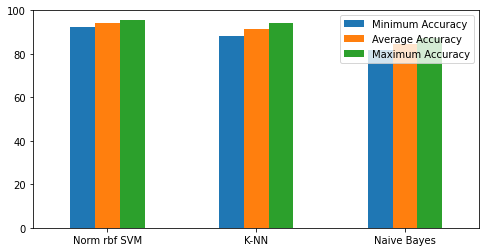

In [6]:
df = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
    },
    index=index
)

ax = df.plot.bar(rot=0, figsize=(8, 4))
ax.set_ylim(0, 100)


Clearly, the SVM classifier outperforms all classifiers in terms of accuracy.